In [2]:
os.chdir('/root/EDA_contrastive_learning/')

In [91]:
!pip install neurokit2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.1/693.1 kB 4.4 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip available: 22.2.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


(72, 240, 1)


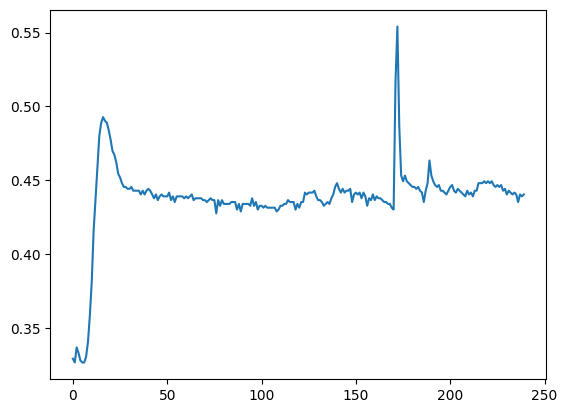

In [280]:
import h5py
import time
import os
import numpy as np 
import matplotlib.pyplot as plt
from glob import glob

def get_data(data_path='./'):
    unlabeled_eda = []
    labeled_eda = []
    labels = []
    for fn in glob(os.path.join(data_path, '*.h5')):
        f = h5py.File(fn, 'r')
        # print(fn, f['eda'].shape)
        unlabeled_eda += f['eda_unlabel']
        labeled_eda += f['eda']
        labels += (np.array(f['label'])==2).astype(np.int32).tolist()
        # print(f['label'])
        break
        # print(len(data))
    return unlabeled_eda, labeled_eda, labels
# data = np.concatenate(data, axis=1)
u_data, l_data, labels = get_data()
data = np.array(l_data)
print(data.shape)
plt.plot(data[0])
plt.show()

In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, ops
from tensorflow.data import Dataset
from sklearn.model_selection import train_test_split

def get_dataset(data_path='./', batch_size=64, test_size=0.2, seed=42):
    unlabeled_eda = []
    labeled_eda = []
    labels = []
    for fn in glob(os.path.join(data_path, '*.h5')):
        f = h5py.File(fn, 'r')
        unlabeled_eda += f['eda_unlabel']
        labeled_eda += f['eda']
        labels += (np.array(f['label'])==2).astype(np.int32).tolist()
    # labels = list(range(len(labeled_eda)))
    X_train, X_test, y_train, y_test = train_test_split(labeled_eda, labels, test_size=test_size, random_state=seed)
    unlabeled_train_ds = Dataset.from_tensor_slices(unlabeled_eda)
    labeled_train_ds = Dataset.from_tensor_slices((X_train, y_train))
    labeled_test_ds = Dataset.from_tensor_slices((X_test, y_test)) \
        .batch(batch_size) \
        .prefetch(buffer_size=tf.data.AUTOTUNE)

    unlabeled_ds_len, labeled_ds_len = unlabeled_train_ds.cardinality(), labeled_train_ds.cardinality()
    steps_per_epoch = (unlabeled_ds_len + labeled_ds_len) // batch_size
    unlabeled_bs = unlabeled_ds_len // steps_per_epoch
    labeled_bs = labeled_ds_len // steps_per_epoch

    train_ds = tf.data.Dataset.zip(
        (unlabeled_train_ds.shuffle(buffer_size=10 * unlabeled_bs).batch(unlabeled_bs), 
         labeled_train_ds.shuffle(buffer_size=10 * labeled_bs).batch(labeled_bs))
    ).prefetch(buffer_size=tf.data.AUTOTUNE)
    
    labeled_train_ds = labeled_train_ds.batch(batch_size) \
        .prefetch(buffer_size=tf.data.AUTOTUNE)

    return train_ds, labeled_train_ds, labeled_test_ds
train_ds, labeled_train_ds, test_ds = get_dataset()

In [391]:
def get_dataset(data_path='./', seg_shape=(240,1), batch_size=64, test_size=0.2, seed=42, unlabeled_aug=None, labeled_aug=None):
    unlabeled_eda = np.zeros((0,*seg_shape))
    labeled_eda = np.zeros((0,*seg_shape))
    unlabeled_lb = np.zeros((0,*seg_shape))
    unlabeled_rb = np.zeros((0,*seg_shape))
    labeled_lb = np.zeros((0,*seg_shape))
    labeled_rb = np.zeros((0,*seg_shape))
    nan = np.full((1,*seg_shape), np.nan)
    labels = []
    start = time.time()
    for fn in glob(os.path.join(data_path, '*.h5')):
        f = h5py.File(fn, 'r')
        unlabeled_eda = np.concat([unlabeled_eda, f['eda_unlabel'][:]], axis=0, dtype=np.float32)
        unlabeled_lb = np.concat([unlabeled_lb, nan, f['eda_unlabel'][:-1]], axis=0, dtype=np.float32)
        unlabeled_rb = np.concat([unlabeled_rb, f['eda_unlabel'][1:], nan], axis=0, dtype=np.float32)
        # print(len(unlabeled_eda), len(unlabeled_lb), len(unlabeled_rb))
        # unlabeled_eda += f['eda_unlabel']
        # unlabeled_lb += nan + f['eda_unlabel'].tolist()[1:] # np.concat([nan + f['eda_unlabel'][1:]], axis=0).tolist()
        # unlabeled_rb += f['eda_unlabel'].tolist()[:-1] + nan# np.concat([f['eda_unlabel'][:-1], nan], axis=0).tolist()

        labeled_eda = np.concat([labeled_eda, f['eda'][:]], axis=0, dtype=np.float32)
        labeled_lb = np.concat([labeled_lb, nan, f['eda'][:-1]], axis=0, dtype=np.float32)
        labeled_rb = np.concat([labeled_rb, f['eda'][1:], nan], axis=0, dtype=np.float32)
        # labeled_eda += f['eda']
        # labeled_lb += nan + f['eda'].tolist()[1:]# np.concat([nan, f['eda'][1:]], axis=0).tolist()
        # labeled_rb += f['eda'].tolist()[:-1] + nan# np.concat([f['eda'][:-1], nan], axis=0).tolist()
        labels += f['label']
    print('gather time:', time.time()-start)
    # labels = list(range(len(labeled_eda)))

    start = time.time()
    # unlabeled_eda, labeled_eda = unlabeled_eda.astype(np.float32), labeled_eda.astype(np.float32)
    labels = (np.array(labels)==2).astype(np.int32)
    X_train, X_test, Xl_train, _, Xr_train, _, y_train, y_test = train_test_split(labeled_eda, labeled_lb, labeled_rb, labels, test_size=test_size, random_state=seed)
    
    if (unlabeled_aug):
        unlabeled_train_ds = Dataset.from_tensor_slices((unlabeled_eda, unlabeled_lb, unlabeled_rb))
        unlabeled_train_ds = Dataset.zip(unlabeled_train_ds.map(unlabeled_aug), unlabeled_train_ds.map(unlabeled_aug))
    else:
        unlabeled_train_ds = Dataset.from_tensor_slices(unlabeled_eda)
        unlabeled_train_ds = Dataset.zip(unlabeled_train_ds, unlabeled_train_ds)
    unlabeled_train_ds = unlabeled_train_ds.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    
    if (labeled_aug):
        labeled_train_ds = Dataset.from_tensor_slices((X_train, Xl_train, Xr_train))
        labeled_train_ds = labeled_train_ds.map(labeled_aug)
        labeled_train_ds = Dataset.zip(labeled_train_ds, Dataset.from_tensor_slices(y_train))
    else:
        labeled_train_ds = Dataset.from_tensor_slices((X_train, y_train))
    labeled_train_ds = labeled_train_ds.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    
    labeled_test_ds = Dataset.from_tensor_slices((X_test, y_test)) \
        .batch(batch_size) \
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    print('ds build time:', time.time()-start)
    
    return unlabeled_train_ds, labeled_train_ds, labeled_test_ds#, (unlabeled_eda, unlabeled_lb, unlabeled_rb)
unlabeled_train_ds, labeled_train_ds, test_ds, *_ = get_dataset(unlabeled_aug=da)



gather time: 0.014297723770141602
ds build time: 0.024132966995239258


In [324]:
V = np.arange(10**8*2, dtype=int).reshape(2,-1)
t1=time.time() ; V64=np.array( V, dtype=np.double); t2=time.time()-t1 ; print( t2 )
t1=time.time() ; V = V.astype(np.double) ; t2=time.time()-t1 ; print( t2 )
t1=time.time() ; x=V.view(np.double);V[:,:]=x ;t2=time.time()-t1 ; print( t2 )

1.1541433334350586
1.1539337635040283
0.009879827499389648


np.False_

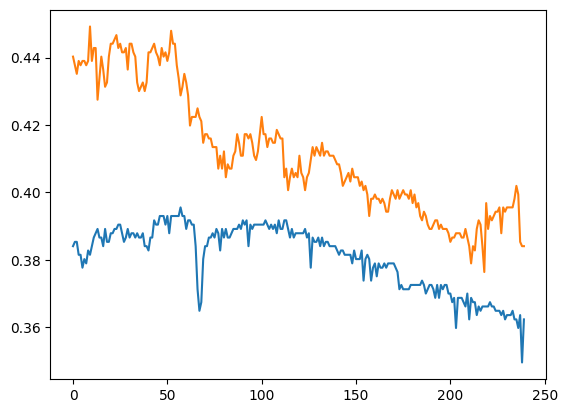

In [390]:
f = h5py.File(glob('./*.h5')[0], 'r')
# type(f['eda_unlabel']), type(f['eda_unlabel'][0:1]), type(f['eda_unlabel'][0])
# a = np.zeros((0,240,1), np.float32)
seg_shape=(240,1)
unlabeled_eda = np.zeros((0,*seg_shape))
unlabeled_rb = np.zeros((0,*seg_shape))
unlabeled_lb = np.zeros((0,*seg_shape))
nan = np.full((1,*seg_shape), np.nan)
unlabeled_eda = np.concat([unlabeled_eda, f['eda_unlabel'][:]], axis=0, dtype=np.float32)
unlabeled_lb = np.concat([unlabeled_lb, nan, f['eda_unlabel'][:-1]], axis=0, dtype=np.float32)
unlabeled_rb = np.concat([unlabeled_rb, f['eda_unlabel'][1:], nan], axis=0, dtype=np.float32)
# b = np.zeros((240,2))
# b[3,1] = np.nan
# a = np.concat([b, np.zeros((240,2)), np.zeros((240,2))], axis=0)
# mask = ~np.bitwise_or.reduce(np.isnan(a), axis=1)
# a[mask].shape

# ds = Dataset.from_tensor_slices(np.concat([np.full((1,3,2), np.nan), np.zeros((1,3,2))], axis=0))
# for d in ds:
#     print(d)
plt.plot(unlabeled_eda[2])
plt.plot(unlabeled_lb[2])
# plt.plot(np.concat([f['eda_unlabel'][0],f['eda_unlabel'][1]]))
# (f['eda_unlabel'][1:]).shape, unlabeled_eda.shape, unlabeled_lb.shape, unlabeled_rb.shape
np.all(unlabeled_eda[2]==unlabeled_lb[2])

In [304]:
print(unlabeled_train_ds.cardinality())
print(Dataset.from_tensor_slices(labels).cardinality())
print(Dataset.from_tensor_slices(l_data).cardinality())
print(len(l_data), l_data[0].shape)
print(type(l_data))

tf.Tensor(23, shape=(), dtype=int64)
tf.Tensor(72, shape=(), dtype=int64)
tf.Tensor(72, shape=(), dtype=int64)
72 (240, 1)
<class 'list'>


In [238]:
AUGMENTERS_DICT = {}

def register_internal_serializable(path, symbol):
    global AUGMENTERS_DICT
    if isinstance(path, (list, tuple)):
        name = path[0]
    else:
        name = path
    AUGMENTERS_DICT[name] = symbol
    
class aug_export:
    def __init__(self, path):
        self.path = path
        # print('init:', path)

    def __call__(self, symbol):
        # print('call:', symbol)
        register_internal_serializable(self.path, symbol)
        return symbol
        
@aug_export('sth.a')
class A:
    def __init__(self, a):
        self.a = a
    def __call__(self, *args, **kwargs):
        print('self.a =', self.a)

In [216]:
AUGMENTERS_DICT['sth.a'](1)

gather time: 0.013949871063232422
ds build time: 0.03387641906738281


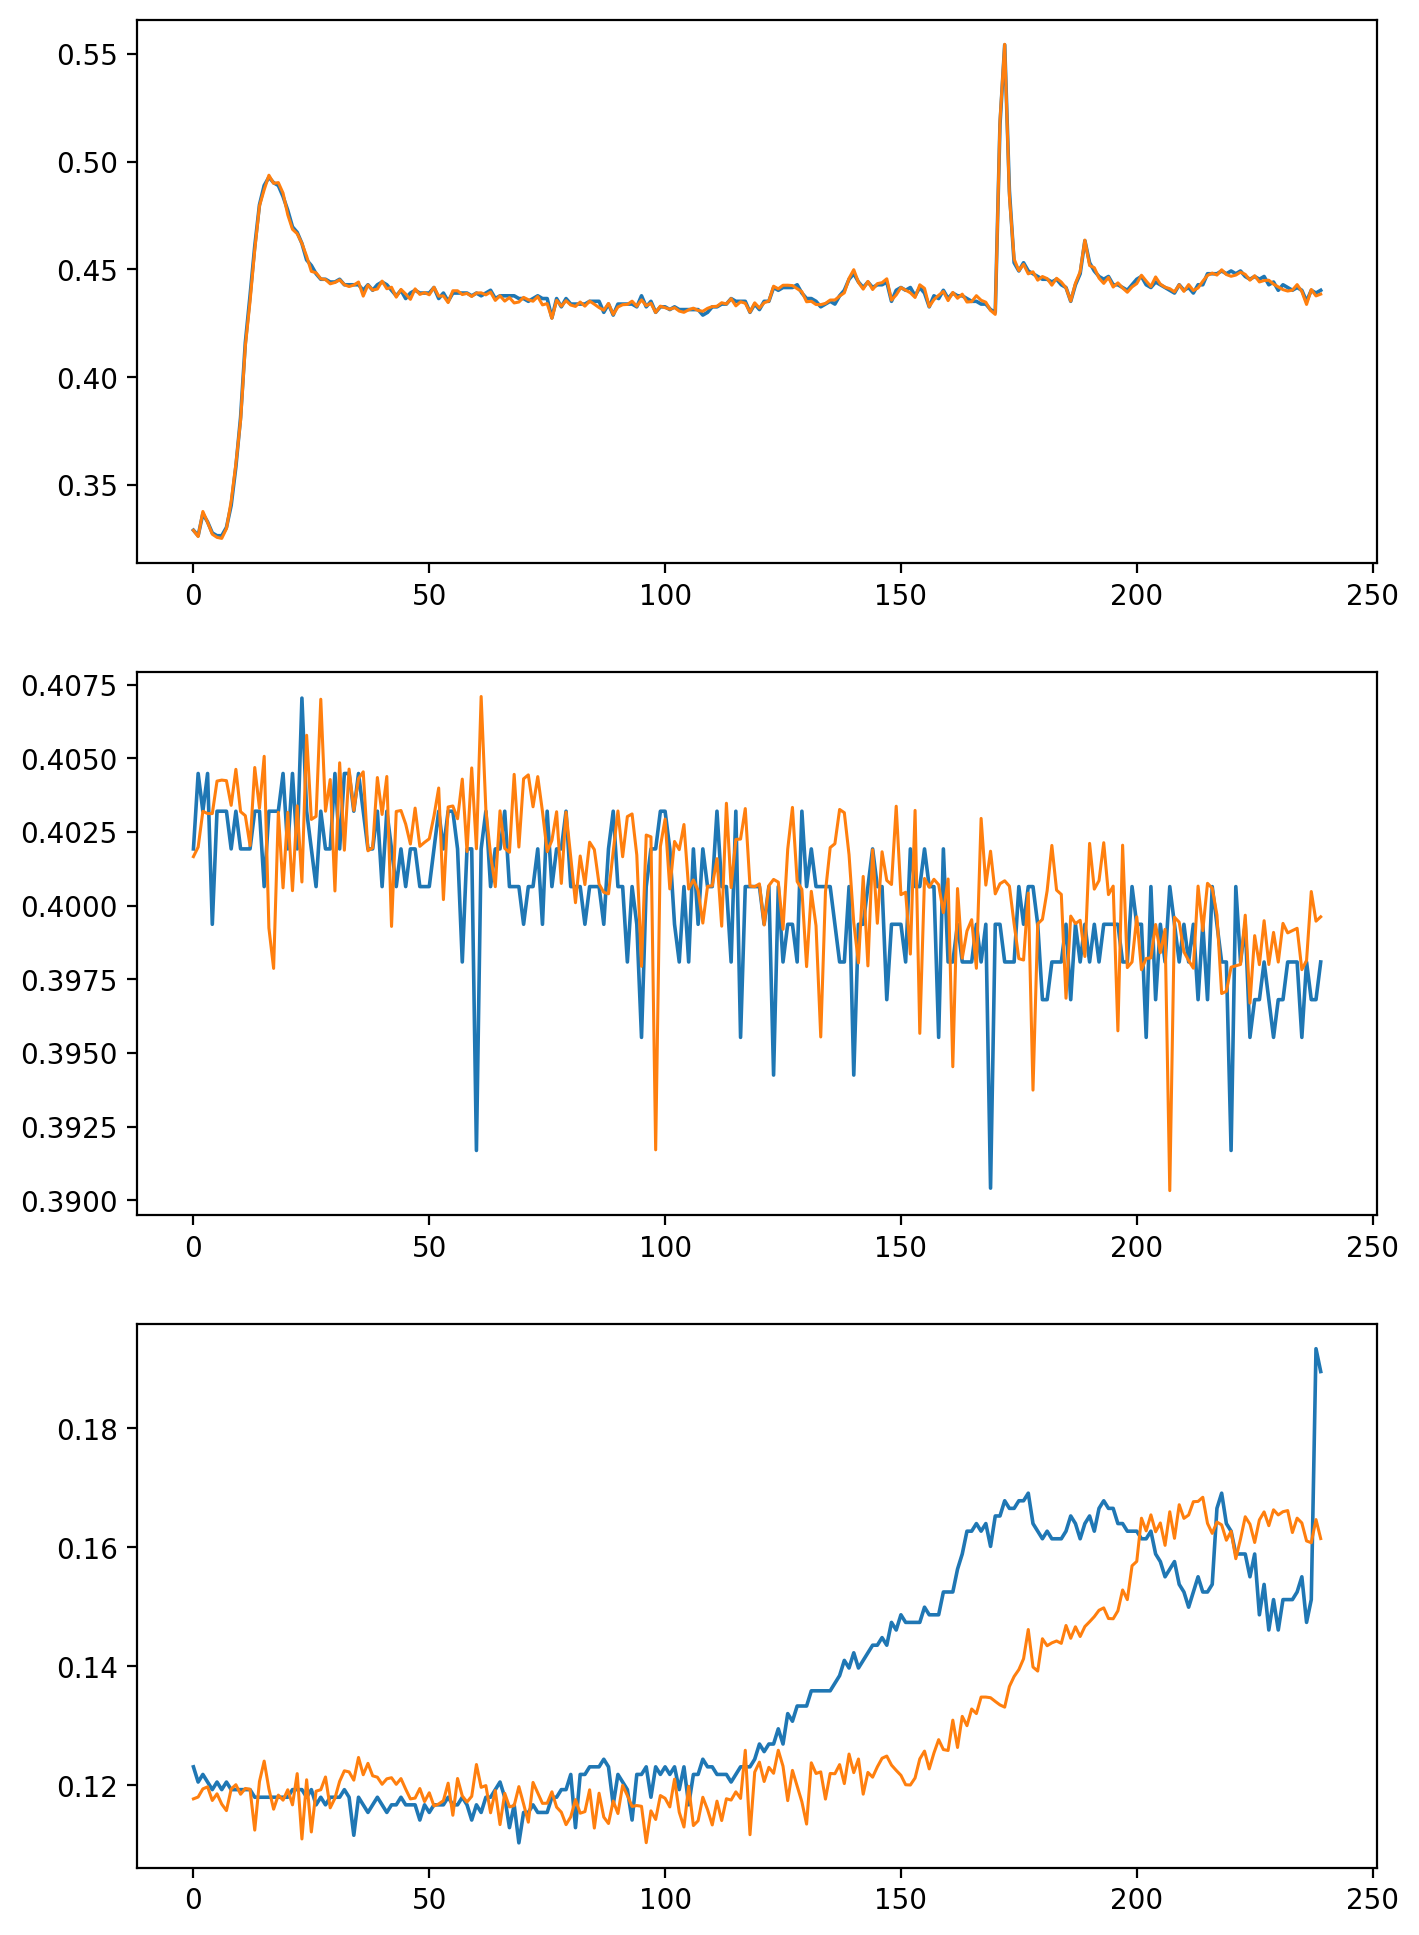

In [399]:
@aug_export('LowPassFilter_Det')
class LowPassFilterDeterministic():
    def __init__(self, data_freq=4, highcut_hz=0.05, **kwargs):
        """
        Apply low pass filter to remove frequency bands >= highcut_hz
        :param data_freq: frequency of data to apply filter to (e.g., 4Hz for EDA)
        :param highcut_hz: lower bound on frequency bands to remove
        """
        self.data_freq = data_freq
        self.highcut_hz = highcut_hz
        self.b, self.a = scipy.signal.butter(4, [highcut_hz], btype="lowpass", output="ba", fs=data_freq)

    def __call__(self, x, *args):
        # print(x.shape)
        segment_filtered = scipy.signal.filtfilt(self.b, self.a, x, axis=0)
        return segment_filtered.astype(np.float32)

@aug_export('GaussianNoise_Det')
class GaussianNoiseDeterministic:
    def __init__(self, sigma_scale=0.1):
        """
        :param sigma_scale: factor to use in computing sigma parameter for noise distribution
            sigma = mean(abs(diff between signal & mean))) * sigma_scale
        """
        self.sigma_scale = sigma_scale

    def __call__(self, x, *args):
        # x = np.squeeze(x, -1)
        mean_power_diff = np.mean(np.abs(x - np.mean(x)))
        noise_sigma = mean_power_diff * self.sigma_scale
        noise = np.random.normal(scale=noise_sigma, size=x.shape)
        # print(noise_sigma)
        return (x + noise).astype(np.float32)

@aug_export('GaussianNoise_Sto')
class GaussianNoiseStochastic:
    def __init__(self, sigma_scale_min=0.0, sigma_scale_max=0.5):
        """
        :param sigma_scale_min: min factor to use in computing sigma parameter for noise distribution
        :param sigma_scale_max: max factor to use in computing sigma parameter for noise distribution
            sample sigma_scale uniformly in [sigma_scale_min, sigma_scale_max)
            sigma = mean(abs(diff between signal & mean))) * sigma_scale
        """
        self.sigma_scale_min = sigma_scale_min
        self.sigma_scale_max = sigma_scale_max

    def __call__(self, x, *args):
        # sample sigma scale
        # x = np.squeeze(x, -1)
        sigma_scale = np.random.uniform(self.sigma_scale_min, self.sigma_scale_max)
        # print(sigma_scale.shape)
        mean_power_diff = np.mean(np.abs(x - np.mean(x)))
        noise_sigma = mean_power_diff * sigma_scale
        noise = np.random.normal(scale=noise_sigma, size=x.shape)
        return (x + noise).astype(np.float32)

@aug_export('BandstopFilter_Det')
class BandstopFilterDeterministic:
    def __init__(self, data_freq=4, remove_freq=0.25, Q=0.707):
        """
        Selects frequency band to remove.
        See https://stackoverflow.com/questions/54320638/how-to-create-a-bandstop-filter-in-python
        :param data_freq: frequency of data to apply filter to (e.g., 4Hz for EDA)
        :param remove_freq: frequency band to remove
        :param Q: "quality factor" Q = remove_freq / width of filter
        see - https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.iirnotch.html
        and https://en.wikipedia.org/wiki/Q_factor
        """
        self.data_freq = data_freq
        self.remove_freq = remove_freq
        self.Q = Q
        self.b, self.a = iirnotch(self.remove_freq, self.Q, fs=self.data_freq)

    def __call__(self, x, *args):
        return filtfilt(self.b, self.a, x, axis=0).astype(np.float32)

@aug_export('TimeShift_Det')
class TimeShiftDeterministic:
    """ Shifts the window left or right by a number of samples """
    def __init__(self, shift_len=120):
        self.shift_len = shift_len

    def __call__(self, x, left_buffer, right_buffer):
        # print(x.shape, left_buffer.shape, right_buffer.shape)
        # drop nans from left and right buffer segment
        l_len = np.bitwise_and.reduce(~np.isnan(left_buffer), axis=1).sum()
        r_len = np.bitwise_and.reduce(~np.isnan(right_buffer), axis=1).sum()
        signal = np.concatenate([left_buffer, x, right_buffer])
        mask = np.bitwise_and.reduce(~np.isnan(signal), axis=1)
        signal = signal[mask]
        # sample shift to apply --- make sure not out-of-bounds!!
        left_shift_len = min(self.shift_len, l_len)
        right_shift_len = min(self.shift_len, r_len)
        shift = np.random.choice([-left_shift_len, right_shift_len])  # choose whether to shift left or right in time
        start_index = l_len + shift
        x_trf = signal[start_index:start_index+len(x)]
        return x_trf.astype(np.float32)

@aug_export('TimeShift_Sto')
class TimeShiftStochastic:
    """ Shifts the window left or right by a number of samples """
    def __init__(self, shift_len_min=120, shift_len_max=240):
        self.shift_min = shift_len_min
        self.shift_max = shift_len_max
        self.shift_lens = np.arange(self.shift_min, self.shift_max, 1)

    def __call__(self, x, left_buffer, right_buffer):
        # drop nans from left and right buffer segment
        l_len = np.bitwise_and.reduce(~np.isnan(left_buffer), axis=1).sum()
        r_len = np.bitwise_and.reduce(~np.isnan(right_buffer), axis=1).sum()
        signal = np.concatenate([left_buffer, x, right_buffer])
        mask = np.bitwise_and.reduce(~np.isnan(signal), axis=1)
        signal = signal[mask]
        # sample shift len to apply
        shift_len = np.random.choice(self.shift_lens)
        # adjust so shift is in bounds & sample whether to apply it on left or right
        left_shift_len = min(shift_len, l_len)
        right_shift_len = min(shift_len, r_len)
        shift = np.random.choice([-left_shift_len, right_shift_len])  # choose whether to shift left or right in time
        start_index = l_len + shift
        x_trf = signal[start_index:start_index+len(x)]
        return x_trf.astype(np.float32)

class DataAugmenter():
    def __init__(self, augment_dict={}, prob=0.5):
        self.augmenters = [AUGMENTERS_DICT[k](**v) for k,v in augment_dict.items()]
        self.prob = prob if isinstance(prob, list) else [prob]*len(self.augmenters)
        
    def __call__(self, x, xl, xr):
        for p, aug in zip(self.prob, self.augmenters):
            if (p > tf.random.uniform(maxval=1, shape=[1])):
                x = tf.numpy_function(aug, [x, xl, xr], [tf.float32])[0]
        return x
    
# augmenters = [
    # GaussianNoiseStochastic(0.25),
    # LowPassFilterDeterministic(highcut_hz=0.2),
    # BandstopFilterDeterministic(),
    # GaussianNoiseDeterministic(0.3),
 # ]
augmenters = {
    # 'GaussianNoise_Sto': {'sigma_scale_min': 0.25},
    # 'LowPassFilter_Det': {'highcut_hz': 0.2},
    # 'BandstopFilter_Det': {},
    'TimeShift_Sto': {'shift_len_min': 20, 'shift_len_max': 40},
    'GaussianNoise_Det': {'sigma_scale': 0.1}
    # 'TimeShift_Det': {'shift_len': 20},
}
# da = DataAugmenter(augmenters, [0.7, 0.5, 1])
da = DataAugmenter(augmenters, 1)
unlabeled_train_ds, labeled_train_ds, test_ds = get_dataset(unlabeled_aug=da)
# unlabeled_train_ds_no_aug, *_ = get_dataset()
samples = 3
plt.figure(figsize=(8, 4*samples), dpi=200)
# ds1 = Dataset.zip(unlabeled_train_ds.map(da),unlabeled_train_ds.map(da))
ds2 = unlabeled_train_ds#.shuffle(128)
# ux, ul, ur = unlabeled_train_ds_buffer
# plt.plot(ux[1], color='green')
# plt.plot(ul[1], color='red')
# plt.plot(ur[1], color='blue')
# for i, (u1, u2) in enumerate(ds1.take(samples)):
#     print(u1.shape, u2.shape, (u1.numpy()==u2.numpy()).all())
for i, (u1, u2) in enumerate(unlabeled_train_ds_no_aug.take(samples)):
    plt.subplot(samples, 1, i+1)
    plt.plot(u1[0], linewidth=1.3)
    # plt.plot(u2, linewidth=1.2)
for i, (u1, u2) in enumerate(ds2.take(samples)):
    # print(u1.shape, u2.shape)
    # u = u1[0]
    plt.subplot(samples, 1, i+1)
    plt.plot(u1[0], linewidth=1.1)
    # plt.plot(u2[0], linewidth=0.8)

In [42]:
def build_encoder():
    return keras.Sequential(
        [
            layers.Input((240,1)),
            layers.Conv1D(4, kernel_size=7, strides=1),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.MaxPool1D(),
            layers.Dropout(0.1),
            layers.Conv1D(16, kernel_size=7, strides=1),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.MaxPool1D(),
            layers.Dropout(0.1),
            layers.Conv1D(32, kernel_size=7, strides=1),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.MaxPool1D(),
            layers.Dropout(0.1),
            layers.Flatten(),
            layers.Dense(64, activation="relu"),
        ],
        name="encoder",
    )

def build_projection_head():
    return keras.Sequential(
        [
            layers.Input((64,)),
            layers.Dense(32, activation="relu"),
        ],
        name="projection_head",
    )

def build_classification_head():
    return keras.Sequential(
        [
            layers.Input((64,)),
            layers.Dense(1, activation="relu"),
        ],
        name="classification_head",
    )
# build_encoder().summary()

# keras.Sequential([build_encoder(), build_projection_head()]).summary()
# keras.Sequential([build_encoder(), build_classification_head()]).summary()

In [46]:
def get_augmenter(stddev=0.1):
    return keras.Sequential([
        layers.GaussianNoise(stddev),
        # LowPassFilterDeterministic()
    ])

In [125]:
class ContrastiveModel(keras.Model):
    def __init__(self, temperature=0.1):
        super().__init__()

        self.temperature = temperature
        self.contrastive_augmenter = get_augmenter(0.5)
        self.classification_augmenter = get_augmenter(0.1)
        self.encoder = build_encoder()
        # Non-linear MLP as projection head
        self.projection_head = build_projection_head()
        # Single dense layer for linear probing
        self.linear_probe = build_classification_head()

        self.encoder.summary()
        self.projection_head.summary()
        self.linear_probe.summary()

    def compile(self, contrastive_optimizer, probe_optimizer, **kwargs):
        super().compile(**kwargs)

        self.contrastive_optimizer = contrastive_optimizer
        self.probe_optimizer = probe_optimizer

        # self.contrastive_loss will be defined as a method
        self.probe_loss = keras.losses.BinaryCrossentropy(from_logits=True)

        self.contrastive_loss_tracker = keras.metrics.Mean(name="c_loss")
        self.contrastive_accuracy = keras.metrics.BinaryAccuracy(name="c_acc")
        self.probe_loss_tracker = keras.metrics.Mean(name="p_loss")
        self.probe_accuracy = keras.metrics.BinaryAccuracy(name="p_acc")

    @property
    def metrics(self):
        return [
            self.contrastive_loss_tracker,
            self.contrastive_accuracy,
            self.probe_loss_tracker,
            self.probe_accuracy,
        ]

    def contrastive_loss(self, projections_1, projections_2):
        # InfoNCE loss (information noise-contrastive estimation)
        # NT-Xent loss (normalized temperature-scaled cross entropy)
        # print(projections_1.shape, projections_2.shape)
        # Cosine similarity: the dot product of the l2-normalized feature vectors
        projections_1 = ops.normalize(projections_1, axis=-1)
        projections_2 = ops.normalize(projections_2, axis=-1)
        # print(projections_1.shape, projections_2.shape)
        # similarities = (
        #     ops.matmul(projections_1, ops.transpose(projections_2)) / self.temperature
        # )
        similarities = (
            keras.losses.cosine_similarity(projections_1, projections_2) / self.temperature
        )
        # The similarity between the representations of two augmented views of the
        # same image should be higher than their similarity with other views
        batch_size = tf.shape(projections_1)[0]
        contrastive_labels = ops.arange(batch_size)
        # print(contrastive_labels.shape, similarities.shape)
        # print(contrastive_labels, similarities, self.contrastive_accuracy.update_state([1], [[0.1,0.9]]))
        self.contrastive_accuracy.update_state(contrastive_labels, similarities)
        self.contrastive_accuracy.update_state(contrastive_labels, ops.transpose(similarities))

        # The temperature-scaled similarities are used as logits for cross-entropy
        # a symmetrized version of the loss is used here
        loss_1_2 = keras.losses.binary_crossentropy(
            contrastive_labels, similarities, from_logits=True
        )
        loss_2_1 = keras.losses.binary_crossentropy(
            contrastive_labels, ops.transpose(similarities), from_logits=True
        )
        return (loss_1_2 + loss_2_1) / 2

    def train_step(self, data):
        images = data

        # Both labeled and unlabeled images are used, without labels
        # images = ops.concatenate((unlabeled_images, labeled_images), axis=0)
        # print(images.shape)
        # Each image is augmented twice, differently
        augmented_images_1 = self.contrastive_augmenter(images, training=True)
        augmented_images_2 = self.contrastive_augmenter(images, training=True)
        with tf.GradientTape() as tape:
            features_1 = self.encoder(augmented_images_1, training=True)
            features_2 = self.encoder(augmented_images_2, training=True)
            # The representations are passed through a projection mlp
            projections_1 = self.projection_head(features_1, training=True)
            projections_2 = self.projection_head(features_2, training=True)
            contrastive_loss = self.contrastive_loss(projections_1, projections_2)
        gradients = tape.gradient(
            contrastive_loss,
            self.encoder.trainable_weights + self.projection_head.trainable_weights,
        )
        self.contrastive_optimizer.apply_gradients(
            zip(
                gradients,
                self.encoder.trainable_weights + self.projection_head.trainable_weights,
            )
        )
        self.contrastive_loss_tracker.update_state(contrastive_loss)

        # Labels are only used in evalutation for an on-the-fly logistic regression
        # preprocessed_images = self.classification_augmenter(
        #     labeled_images, training=True
        # )
        # with tf.GradientTape() as tape:
        #     # the encoder is used in inference mode here to avoid regularization
        #     # and updating the batch normalization paramers if they are used
        #     features = self.encoder(preprocessed_images, training=False)
        #     class_logits = self.linear_probe(features, training=True)
        #     probe_loss = self.probe_loss(labels, class_logits)
        # gradients = tape.gradient(probe_loss, self.linear_probe.trainable_weights)
        # self.probe_optimizer.apply_gradients(
        #     zip(gradients, self.linear_probe.trainable_weights)
        # )
        # self.probe_loss_tracker.update_state(probe_loss)
        # self.probe_accuracy.update_state(labels, class_logits)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        labeled_images, labels = data

        # For testing the components are used with a training=False flag
        preprocessed_images = self.classification_augmenter(
            labeled_images, training=False
        )
        features = self.encoder(preprocessed_images, training=False)
        class_logits = self.linear_probe(features, training=False)
        probe_loss = self.probe_loss(labels, class_logits)
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)

        # Only the probe metrics are logged at test time
        return {m.name: m.result() for m in self.metrics[2:]}


# Contrastive pretraining
pretraining_model = ContrastiveModel()
pretraining_model.compile(
    contrastive_optimizer=keras.optimizers.Adam(),
    probe_optimizer=keras.optimizers.Adam(),
)

pretraining_history = pretraining_model.fit(
    unlabeled_train_ds, epochs=30, validation_data=test_ds
)
print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(pretraining_history.history["val_p_acc"]) * 100
    )
)

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_48 (Conv1D)              │ (None, 234, 4)         │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_48          │ (None, 234, 4)         │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_48 (Activation)      │ (None, 234, 4)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_48 (MaxPooling1D) │ (None, 117, 4)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 117, 4)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_49 (Conv1D)              │ (None, 111, 16)        │           464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_49          │ (None, 111, 16)        │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_49 (Activation)      │ (None, 111, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_49 (MaxPooling1D) │ (None, 55, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 55, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_50 (Conv1D)              │ (None, 49, 32)         │         3,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_50          │ (None, 49, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_50 (Activation)      │ (None, 49, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_50 (MaxPooling1D) │ (None, 24, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 24, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 64)             │        49,216 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,536 (209.12 KB)

 Trainable params: 53,432 (208.72 KB)

 Non-trainable params: 104 (416.00 B)

Model: "projection_head"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_45 (Dense)                │ (None, 32)             │         2,080 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,080 (8.12 KB)

 Trainable params: 2,080 (8.12 KB)

 Non-trainable params: 0 (0.00 B)

Model: "classification_head"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_46 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65 (260.00 B)

 Trainable params: 65 (260.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - c_acc: 0.0156 - c_loss: 114.4446 - p_acc: 0.0000e+00 - p_loss: 0.0000e+00 - val_p_loss: 0.6970 - val_p_acc: 0.8525
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - c_acc: 0.0156 - c_loss: 24.0976 - p_acc: 0.0000e+00 - p_loss: 0.0000e+00 - val_p_loss: 0.7149 - val_p_acc: 0.8525
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - c_acc: 0.0156 - c_loss: 14.1829 - p_acc: 0.0000e+00 - p_loss: 0.0000e+00 - val_p_loss: 0.7739 - val_p_acc: 0.8484
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - c_acc: 0.0156 - c_loss: 26.0709 - p_acc: 0.0000e+00 - p_loss: 0.0000e+00 - val_p_loss: 0.7557 - val_p_acc: 0.8484
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - c_acc: 0.0156 - c_loss: 13.5484 - p_acc: 0.0000e+00 - p_loss: 0.0000e+00 - val_p_loss: 0.7509 - val_p_acc: 0.8443
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - c_acc: 0.0156 - c_loss: 17.6304 - p_acc: 0.0000e+00 - p_loss: 0.0000e+00 - val_p_loss: 0.8558 - val_p_acc: 0.6680
Epo

In [131]:
sl_model = keras.Sequential([build_encoder(), build_classification_head()])
sl_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[
        keras.metrics.BinaryAccuracy(),
    ],
)

sl_history = sl_model.fit(
    labeled_train_ds, epochs=30, validation_data=test_ds
)
print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(sl_history.history["val_binary_accuracy"]) * 100
    )
)

Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - binary_accuracy: 0.8147 - loss: 0.7245 - val_binary_accuracy: 0.8525 - val_loss: 0.6931
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.8654 - loss: 0.6931 - val_binary_accuracy: 0.8525 - val_loss: 0.6931
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.8654 - loss: 0.6931 - val_binary_accuracy: 0.8525 - val_loss: 0.6931
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.8654 - loss: 0.6931 - val_binary_accuracy: 0.8525 - val_loss: 0.6931
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.8654 - loss: 0.6931 - val_binary_accuracy: 0.8525 - val_loss: 0.6931
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.8654 - loss: 0.6931 - val_binary_accuracy: 0.8525 - val_loss: 0.6931
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.8654 - loss: 0.6931 - val_binary_accuracy: 0.8525 - val_loss: 0.6931
Epoch 8/30
16/16 ━━━

In [41]:
import copy
from sys import exit
from functools import lru_cache

import neurokit2 as nk
import numpy as np
import scipy
from scipy.fft import fft, ifft
from scipy.signal import iirnotch, iirpeak, filtfilt
from scipy.interpolate import CubicSpline

class GaussianNoiseDeterministic:
    def __init__(self, sigma_scale=0.1):
        """
        :param sigma_scale: factor to use in computing sigma parameter for noise distribution
            sigma = mean(abs(diff between signal & mean))) * sigma_scale
        """
        self.sigma_scale = sigma_scale

    def __call__(self, sample_dict):
        x = sample_dict['x']
        mean_power_diff = np.mean(np.abs(x - np.mean(x)))
        noise_sigma = mean_power_diff * self.sigma_scale
        noise = np.random.normal(scale=noise_sigma, size=len(x))
        return x + noise


class GaussianNoiseStochastic:
    def __init__(self, sigma_scale_min=0.0, sigma_scale_max=0.5):
        """
        :param sigma_scale_min: min factor to use in computing sigma parameter for noise distribution
        :param sigma_scale_max: max factor to use in computing sigma parameter for noise distribution
            sample sigma_scale uniformly in [sigma_scale_min, sigma_scale_max)
            sigma = mean(abs(diff between signal & mean))) * sigma_scale
        """
        self.sigma_scale_min = sigma_scale_min
        self.sigma_scale_max = sigma_scale_max

    def __call__(self, sample_dict):
        x = sample_dict['x']
        # sample sigma scale
        sigma_scale = np.random.uniform(self.sigma_scale_min, self.sigma_scale_max)
        mean_power_diff = np.mean(np.abs(x - np.mean(x)))
        noise_sigma = mean_power_diff * sigma_scale
        noise = np.random.normal(scale=noise_sigma, size=len(x))
        return x + noise


class Identity:
    def __call__(self, sample_dict):
        return sample_dict['x']


class LowPassFilterDeterministic(layers.Layer):
    def __init__(self, data_freq=4, highcut_hz=0.05, **kwargs):
        """
        Apply low pass filter to remove frequency bands >= highcut_hz
        :param data_freq: frequency of data to apply filter to (e.g., 4Hz for EDA)
        :param highcut_hz: lower bound on frequency bands to remove
        """
        super(LowPassFilterDeterministic, self).__init__(**kwargs)
        self.data_freq = data_freq
        self.highcut_hz = highcut_hz
        self.b, self.a = scipy.signal.butter(4, [highcut_hz], btype="lowpass", output="ba", fs=data_freq)

    def __call__(self, inputs):
        print(inputs)
        segment_filtered = scipy.signal.filtfilt(self.b, self.a, inputs, axis=1)
        return segment_filtered


@lru_cache(maxsize=None)
def memoize_scipy_lowpass_butter_design_ba(order, highcut_hz, fs):
    b, a = scipy.signal.butter(order, [highcut_hz], btype="lowpass", output="ba", fs=fs)
    return b, a


class LowPassFilterStochastic:
    def __init__(self, data_freq=4, highcut_hz_min=0.01, highcut_hz_max=1, n_steps=1000):
        """
        Apply low pass filter to remove frequency bands >= highcut_hz
        :param data_freq: frequency of data to apply filter to (e.g., 4Hz for EDA)
        :param highcut_hz_min: min cutoff freq to use
        :param highcut_hz_max: max cutoff freq to use (sample from [min, max))
        """
        self.data_freq = data_freq
        self.highcut_hz_min = highcut_hz_min
        self.highcut_hz_max = highcut_hz_max
        self.n_steps = n_steps

    def __call__(self, sample_dict):
        x = sample_dict['x']
        # discretise the space so we get some speed benefits 
        highcut_hz = np.random.choice(np.linspace(self.highcut_hz_min, self.highcut_hz_max, self.n_steps))
        b, a = memoize_scipy_lowpass_butter_design_ba(
            order=4, highcut_hz=highcut_hz, fs=self.data_freq,
        )
        segment_filtered = scipy.signal.filtfilt(b, a, x)
        return segment_filtered


class HighPassFilterDeterministic:
    def __init__(self, data_freq=4, lowcut_hz=0.05):
        """
        Apply high pass filter to remove frequency bands <= lowcut_hz
        :param data_freq: frequency of data to apply filter to (e.g., 4Hz for EDA)
        :param lowcut_hz: upper bound on frequency bands to remove
        """
        self.data_freq = data_freq
        self.lowcut_hz = lowcut_hz
        self.b, self.a = scipy.signal.butter(4, [lowcut_hz], btype="highpass", output="ba", fs=data_freq)

    def __call__(self, sample_dict):
        x = sample_dict['x']
        segment_filtered = scipy.signal.filtfilt(self.b, self.a, x)
        return segment_filtered
    

@lru_cache(maxsize=None)
def memoize_scipy_highpass_butter_design_ba(order, lowcut_hz, fs):
    b, a = scipy.signal.butter(order, [lowcut_hz], btype="highpass", output="ba", fs=fs)
    return b, a


class HighPassFilterStochastic:
    def __init__(self, data_freq=4, lowcut_hz_min=0.01, lowcut_hz_max=1, n_steps=1000):
        """
        Apply high pass filter to remove frequency bands <= lowcut_hz
        :param data_freq: frequency of data to apply filter to (e.g., 4Hz for EDA)
        :param lowcut_hz: upper bound on frequency bands to remove
        """
        self.data_freq = data_freq
        self.lowcut_hz_min = lowcut_hz_min
        self.lowcut_hz_max = lowcut_hz_max
        self.n_steps = n_steps

    def __call__(self, sample_dict):
        x = sample_dict['x']
        lowcut_hz = np.random.choice(np.linspace(self.lowcut_hz_min, self.lowcut_hz_max, self.n_steps))
        b, a = memoize_scipy_highpass_butter_design_ba(
            order=4, lowcut_hz=lowcut_hz, fs=self.data_freq,
        )
        segment_filtered = scipy.signal.filtfilt(b, a, x)
        return segment_filtered


class HighFrequencyNoiseDeterministic:
    def __init__(self, sigma_scale=0.1, freq_bin_start_idx=60, freq_bin_stop_idx=120):
        self.sigma_scale = sigma_scale
        self.freq_bin_start_idx = freq_bin_start_idx
        self.req_bin_stop_idx = freq_bin_stop_idx
        self.freq_bin_idxs = np.arange(freq_bin_start_idx, freq_bin_stop_idx)

    def __call__(self, sample_dict):
        x = sample_dict['x']
        x_fft = fft(x)
        mean_fft_val = np.mean(np.abs(x_fft))
        sigma = self.sigma_scale * mean_fft_val
        noise = np.random.normal(scale=sigma, size=len(self.freq_bin_idxs))
        x_fft[self.freq_bin_idxs] += noise
        # get the corresponding negative bins
        neg_end_idx = len(x) + 1 - self.freq_bin_start_idx
        neg_start_idx = neg_end_idx - len(self.freq_bin_idxs)
        x_fft[neg_start_idx:neg_end_idx] += np.flip(noise)
        x_ifft = np.abs(ifft(x_fft))
        return x_ifft


class HighFrequencyNoiseStochastic:
    def __init__(self, sigma_scale_min=0.0, sigma_scale_max=1.0, freq_bin_start_idx=60, freq_bin_stop_idx=120):
        self.sigma_scale_min = sigma_scale_min
        self.sigma_scale_max = sigma_scale_max
        self.freq_bin_start_idx = freq_bin_start_idx
        self.req_bin_stop_idx = freq_bin_stop_idx
        self.freq_bin_idxs = np.arange(freq_bin_start_idx, freq_bin_stop_idx)

    def __call__(self, sample_dict):
        x = sample_dict['x']
        x_fft = fft(x)
        mean_fft_val = np.mean(np.abs(x_fft))
        # sample sigma scale
        sigma_scale = np.random.uniform(self.sigma_scale_min, self.sigma_scale_max)
        sigma = sigma_scale * mean_fft_val
        noise = np.random.normal(scale=sigma, size=len(self.freq_bin_idxs))
        x_fft[self.freq_bin_idxs] += noise
        # get the corresponding negative bins
        neg_end_idx = len(x) + 1 - self.freq_bin_start_idx
        neg_start_idx = neg_end_idx - len(self.freq_bin_idxs)
        x_fft[neg_start_idx:neg_end_idx] += np.flip(noise)
        x_ifft = np.abs(ifft(x_fft))
        return x_ifft


class BandstopFilterDeterministic:
    def __init__(self, data_freq=4, remove_freq=0.25, Q=0.707):
        """
        Selects frequency band to remove.
        See https://stackoverflow.com/questions/54320638/how-to-create-a-bandstop-filter-in-python
        :param data_freq: frequency of data to apply filter to (e.g., 4Hz for EDA)
        :param remove_freq: frequency band to remove
        :param Q: "quality factor" Q = remove_freq / width of filter
        see - https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.iirnotch.html
        and https://en.wikipedia.org/wiki/Q_factor
        """
        self.data_freq = data_freq
        self.remove_freq = remove_freq
        self.Q = Q
        self.b, self.a = iirnotch(self.remove_freq, self.Q, fs=self.data_freq)

    def __call__(self, sample_dict):
        x = sample_dict['x']
        return filtfilt(self.b, self.a, x)


class BandstopFilterStochastic:
    def __init__(self, data_freq=4, remove_freq_min=0.01, remove_freq_max=1.0, Q=0.707):
        """
        Randomly selects frequency band to remove.
        See https://stackoverflow.com/questions/54320638/how-to-create-a-bandstop-filter-in-python
        :param data_freq: frequency of data to apply filter to (e.g., 4Hz for EDA)
        :param remove_freq_min: minimum frequency band to remove
        :param remove_freq_max: maximum frequency band to remove (sample remove_freq from uniform [min, max))
        :param Q: "quality factor" Q = remove_freq / width of filter
        see - https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.iirnotch.html
        and https://en.wikipedia.org/wiki/Q_factor
        """
        self.data_freq = data_freq
        self.remove_feq_min = remove_freq_min
        self.remove_freq_max = remove_freq_max
        self.Q = Q

    def __call__(self, sample_dict):
        x = sample_dict['x']
        # sample frequency band to remove
        remove_freq = np.random.uniform(self.remove_feq_min, self.remove_freq_max)
        b, a = iirnotch(remove_freq, self.Q, fs=self.data_freq)
        return filtfilt(b, a, x)


class BandpassFilterDeterministic:
    def __init__(self, data_freq=4, keep_freq=0.25, Q=0.707):
        """
        Select frequency band to keep
        :param keep_freq: central frequency to keep
        :param Q: "quality factor" Q = width of filter
        """
        self.data_freq = data_freq
        self.keep_freq = keep_freq
        self.Q = Q
        self.b, self.a = iirpeak(self.keep_freq, self.Q, fs=self.data_freq)

    def __call__(self, sample_dict):
        x = sample_dict['x']
        return filtfilt(self.b, self.a, x)
    

class BandpassFilterStochastic:
    def __init__(self, data_freq=4, keep_freq_min=0.01, keep_freq_max=1, Q=0.707):
        """
        Randomly selects frequency band to keep
        :param keep_freq_min: min central frequency to keep
        :param keep_freq_max: max central frequency to keep
        :param Q: "quality factor" Q = width of filter
        """
        self.data_freq = data_freq
        self.keep_freq_min = keep_freq_min
        self.keep_freq_max = keep_freq_max
        self.Q = Q

    def __call__(self, sample_dict):
        x = sample_dict['x']
        keep_freq = np.random.uniform(self.keep_freq_min, self.keep_freq_max)
        b, a = iirpeak(keep_freq, self.Q, fs=self.data_freq)
        return filtfilt(b, a, x)


class TemporalCutoutDeterministic:
    """ Cutouts / Masks a section of the signal window """
    def __init__(self, cutout_size=100):
        self.cutout_size = cutout_size

    def __call__(self, sample_dict):
        x = sample_dict['x']
        # randomly sample cutout start
        start_min = 0
        start_max = len(x) - self.cutout_size
        cutout_start = np.random.choice(np.arange(start_min, start_max))
        x_trf = copy.deepcopy(x)
        x_trf[cutout_start:cutout_start+self.cutout_size] = 0
        return x_trf


class TemporalCutoutStochastic:
    """ Cutouts / Masks a section of the signal window """
    def __init__(self, cutout_size_min=1, cutout_size_max=120):
        self.cutout_size_min = cutout_size_min
        self.cutout_size_max = cutout_size_max

    def __call__(self, sample_dict):
        x = sample_dict['x']
        cutout_size = np.random.choice(np.arange(self.cutout_size_min, self.cutout_size_max+1))
        start_min = 0
        start_max = len(x) - cutout_size
        cutout_start = np.random.choice(np.arange(start_min, start_max+1))
        x_trf = copy.deepcopy(x)
        x_trf[cutout_start:cutout_start+cutout_size] = 0
        return x_trf


class PermuteDeterministic:
    """ Splits segments into chunks and permutes them """
    def __init__(self, n_splits=10):
        self.n_splits = n_splits

    def __call__(self, sample_dict):
        x = sample_dict['x']
        orig_steps = np.arange(x.shape[0])
        splits = np.array_split(orig_steps, self.n_splits)
        np.random.shuffle(splits)
        warp_idx = np.concatenate(splits)
        x_warped = x[warp_idx]
        return x_warped


class PermuteStochastic:
    """ Splits segments into chunks and permutes them """
    def __init__(self, n_splits_max=10):
        self.n_splits_max = n_splits_max

    def __call__(self, sample_dict):
        x = sample_dict['x']
        orig_steps = np.arange(x.shape[0])
        num_splits = np.random.randint(2, self.n_splits_max)
        splits = np.array_split(orig_steps, num_splits)
        np.random.shuffle(splits)
        warp_idx = np.concatenate(splits)
        x_warped = x[warp_idx]
        return x_warped


class Flip:
    """ Flips segments around horizontal axis """
    def __call__(self, sample_dict):
        x = sample_dict['x']
        flip = -1
        x_flip = flip * x + (2 * np.mean(x))
        return x_flip


class TimeShiftDeterministic:
    """ Shifts the window left or right by a number of samples """
    def __init__(self, shift_len=120):
        self.shift_len = shift_len

    def __call__(self, sample_dict):
        # compose x with left and right buffer
        left_buffer = sample_dict['x_left_buffer']
        right_buffer = sample_dict['x_right_buffer']
        # drop nans from left and right buffer segment['x_left_buffer']
        left_buffer = left_buffer[~np.isnan(left_buffer)]
        right_buffer = right_buffer[~np.isnan(right_buffer)]
        x = sample_dict['x']
        signal = np.concatenate([left_buffer, x, right_buffer])
        # sample shift to apply --- make sure not out-of-bounds!!
        left_shift_len = min(self.shift_len, len(left_buffer))
        right_shift_len = min(self.shift_len, len(right_buffer))
        shift = np.random.choice([-left_shift_len, right_shift_len])  # choose whether to shift left or right in time
        start_index = len(left_buffer) + shift
        x_trf = signal[start_index:start_index+len(x)]
        return x_trf


class TimeShiftStochastic:
    """ Shifts the window left or right by a number of samples """
    def __init__(self, shift_len_min=120, shift_len_max=240):
        self.shift_min = shift_len_min
        self.shift_max = shift_len_max
        self.shift_lens = np.arange(self.shift_min, self.shift_max, 1)

    def __call__(self, sample_dict):
        # compose x with left and right buffer
        left_buffer = sample_dict['x_left_buffer']
        right_buffer = sample_dict['x_right_buffer']
        # drop nans from left and right buffer segment['x_left_buffer']
        left_buffer = left_buffer[~np.isnan(left_buffer)]
        right_buffer = right_buffer[~np.isnan(right_buffer)]
        x = sample_dict['x']
        signal = np.concatenate([left_buffer, x, right_buffer])
        # sample shift len to apply
        shift_len = np.random.choice(self.shift_lens)
        # adjust so shift is in bounds & sample whether to apply it on left or right
        left_shift_len = min(shift_len, len(left_buffer))
        right_shift_len = min(shift_len, len(right_buffer))
        shift = np.random.choice([-left_shift_len, right_shift_len])  # choose whether to shift left or right in time
        start_index = len(left_buffer) + shift
        x_trf = signal[start_index:start_index+len(x)]
        return x_trf


class TimeWarpingDeterministic:
    """ 
    Warps the signal across time by creating a spline, warping time, 
    and then interpolating the signal back to the orignal time steps.
    See: https://arxiv.org/pdf/2007.15951.pdf
    """
    def __init__(self, sigma=0.25, knot=4):
        self.sigma = sigma
        self.knot = knot

    def __call__(self, sample_dict):
        x = sample_dict['x']
        
        orig_steps = np.arange(x.shape[0])

        random_warps = np.random.normal(loc=1.0, scale=self.sigma, size=(self.knot+2))
        warp_steps = (np.linspace(0, x.shape[0]-1, num=self.knot+2)).T

        # warps time to != 240
        time_warp = CubicSpline(warp_steps, warp_steps * random_warps)(orig_steps)  
        # scales the warping back to the window length
        scale = (x.shape[0]-1)/time_warp[-1]  
        # using the warped time steps and the original signal, linearly interpolate back onto the original time steps 
        x_time_warped = np.interp(orig_steps, np.clip(scale*time_warp, 0, x.shape[0]-1), x).T
        
        return x_time_warped
    

class TimeWarpingStochastic:
    """ 
    Warps the signal across time by creating a spline, warping time, 
    and then interpolating the signal back to the orignal time steps.
    See: https://arxiv.org/pdf/2007.15951.pdf
    """
    def __init__(self, sigma_min=0.01, sigma_max=0.25, knot_min=1, knot_max=4):
        self.sigma_min = sigma_min
        self.sigma_max = sigma_max
        self.knot_min = knot_min
        self.knot_max = knot_max

    def __call__(self, sample_dict):
        x = sample_dict['x']
        
        sigma = np.random.uniform(self.sigma_min, self.sigma_max)
        knot = np.random.choice(np.arange(self.knot_min, self.knot_max+1))

        orig_steps = np.arange(x.shape[0])
        random_warps = np.random.normal(loc=1.0, scale=sigma, size=(knot+2))
        warp_steps = (np.linspace(0, x.shape[0]-1, num=knot+2)).T

        # warps time to != 240
        time_warp = CubicSpline(warp_steps, warp_steps * random_warps)(orig_steps)  
        # scales the warping back to the window length
        scale = (x.shape[0]-1)/time_warp[-1]  
        # using the warped time steps and the original signal, linearly interpolate back onto the original time steps 
        x_time_warped = np.interp(orig_steps, np.clip(scale*time_warp, 0, x.shape[0]-1), x).T
        
        return x_time_warped


class ExtractComponent:
    def __init__(self, component, method="highpass"):
        self.component = component
        self.method = method

    def __call__(self, sample_dict):
        print("method", self.method)
        x = sample_dict['x']
        decomposed = nk.eda_phasic(x, sampling_rate=4, method=self.method)
        return decomposed[f"EDA_{self.component}"].to_numpy()


class ExtractPhasic(ExtractComponent):
    def __init__(self, method="highpass"):
        print("extract phasic")
        super().__init__("Phasic", method)


class ExtractTonic(ExtractComponent):
    def __init__(self, method="highpass"):
        print("extract tonic")
        super().__init__("Tonic", method)


class LooseSensorArtifactDeterministic:
    def __init__(self, width=4, smooth_width_min=2, smooth_width_max=80):
        self.width = width
        self.smooth_width_min = smooth_width_min
        self.smooth_width_max = smooth_width_max

    def __call__(self, sample_dict):
        x = sample_dict['x']
        
        # sample width of artifact
        artifact_width = self.width
        # sample artifact start
        artifact_start = np.random.choice(np.arange(0, len(x) - artifact_width + 1))
        # compute artifact end (inclusive)
        artifact_end = artifact_start + artifact_width - 1
        
        # don't smooth if artifact goes all the way to boundary
        smooth_left = (artifact_start != 0)
        smooth_right = (artifact_end != len(x) - 1)
        
        # sample smoothing edge widths
        smooth_max = min(self.smooth_width_max, int(artifact_width/2))
        smooth_width1 = np.random.choice(np.arange(self.smooth_width_min, smooth_max + 1)) if smooth_left else 0
        smooth_width2 = np.random.choice(np.arange(self.smooth_width_min, smooth_max + 1)) if smooth_right else 0
        
        # add drop to non-smoothed regions of artifact
        noisy_segment = copy.deepcopy(x)
        drop_start = artifact_start + smooth_width1
        drop_end = artifact_end - smooth_width2  # (inclusive)
        # get mean amplitude of signal in this range
        mean_amp = np.mean(noisy_segment[drop_start:drop_end + 1])  # +1 so inclusive
        # subtract from signal
        noisy_segment[drop_start:drop_end + 1] -= mean_amp
        # zero out negative entries
        noisy_segment[noisy_segment < 0] = 0
        
        # fill in parts to be smoothed
        # fit cubic spline
        # get pre-smooth, unsmoothed artifact, post-smooth
        train_x = np.concatenate([
            np.arange(artifact_start),  # don't include artifact start
            np.arange(drop_start, drop_end + 1),  # include drop end
            np.arange(artifact_end + 1, len(x)) # don't include artifact end
        ])
        train_y = np.concatenate([
            noisy_segment[:artifact_start],
            noisy_segment[drop_start:drop_end + 1],
            noisy_segment[artifact_end + 1:]
        ])
        spline = CubicSpline(train_x, train_y)
        # fill in smoothed parts
        if artifact_start != drop_start:
            noisy_segment[artifact_start:drop_start] = spline(np.arange(artifact_start, drop_start))
        if artifact_end != drop_end:
            noisy_segment[drop_end + 1:artifact_end + 1] = spline(np.arange(drop_end + 1, artifact_end + 1))  # include artifact end
        return noisy_segment


class LooseSensorArtifactStochastic:
    def __init__(self, width_min=4, width_max=120, smooth_width_min=2, smooth_width_max=20):
        self.width_min = width_min
        self.width_max = width_max
        self.smooth_width_min = smooth_width_min
        self.smooth_width_max = smooth_width_max

    def __call__(self, sample_dict):
        x = sample_dict['x']
        
        # sample width of artifact
        artifact_width = np.random.choice(np.arange(self.width_min, self.width_max + 1))  # +1 so its inclusive

        # sample artifact start
        artifact_start = np.random.choice(np.arange(0, len(x) - artifact_width + 1))
        # compute artifact end (inclusive)
        artifact_end = artifact_start + artifact_width - 1
        
        # don't smooth if artifact goes all the way to boundary
        smooth_left = (artifact_start != 0)
        smooth_right = (artifact_end != len(x) - 1)
        
        # sample smoothing edge widths
        smooth_available = int((artifact_width-2)/2)  # need to leave at least 2 dropped out samples
        smooth_max = min(self.smooth_width_max, smooth_available)
        smooth_min = min(smooth_max, self.smooth_width_min)
        smooth_width1 = np.random.choice(np.arange(smooth_min, smooth_max + 1)) if smooth_left else 0
        smooth_width2 = np.random.choice(np.arange(smooth_min, smooth_max + 1)) if smooth_right else 0
        
        # add drop to non-smoothed regions of artifact
        noisy_segment = copy.deepcopy(x)
        drop_start = artifact_start + smooth_width1
        drop_end = artifact_end - smooth_width2  # (inclusive)
        # get mean amplitude of signal in this range
        mean_amp = np.mean(noisy_segment[drop_start:drop_end + 1])  # +1 so inclusive
        # subtract from signal
        noisy_segment[drop_start:drop_end + 1] -= mean_amp
        # zero out negative entries
        noisy_segment[noisy_segment < 0] = 0
        
        # fill in parts to be smoothed
        # fit cubic spline
        # get pre-smooth, unsmoothed artifact, post-smooth
        train_x = np.concatenate([
            np.arange(artifact_start),  # don't include artifact start
            np.arange(drop_start, drop_end + 1),  # include drop end
            np.arange(artifact_end + 1, len(x)) # don't include artifact end
        ])
        train_y = np.concatenate([
            noisy_segment[:artifact_start],
            noisy_segment[drop_start:drop_end + 1],
            noisy_segment[artifact_end + 1:]
        ])
        spline = CubicSpline(train_x, train_y)
        # fill in smoothed parts
        if artifact_start != drop_start:
            noisy_segment[artifact_start:drop_start] = spline(np.arange(artifact_start, drop_start))
        if artifact_end != drop_end:
            noisy_segment[drop_end + 1:artifact_end + 1] = spline(np.arange(drop_end + 1, artifact_end + 1))  # include artifact end
        return noisy_segment


class JumpArtifactDeterministic:
    def __init__(self, max_n_jumps=2, shift_factor=0.1, smooth_width_min=2, smooth_width_max=12):
        self.max_n_jumps = max_n_jumps
        self.shift_factor = shift_factor
        self.smooth_width_min = smooth_width_min
        self.smooth_width_max = smooth_width_max

    def __call__(self, sample_dict):
        x = sample_dict['x']
        noisy_segment = copy.deepcopy(x)
        
        # time flip so we can apply the logic below in either direction
        time_flip = np.random.choice([-1, 1]) 
        if time_flip == -1:
            noisy_segment = np.flip(noisy_segment)
        
        # sample n artifacts
        n_jumps = np.random.choice(np.arange(1, self.max_n_jumps + 1)) # make inclusive
        
        # sample artifact starts and shift factors
        min_start = 1 # don't start at 0 because this would shift whole segment instead of creating jump
        # needs to start early enough that there is enough room to smooth jump (with smallest smoothing window)
        max_start = len(x) - self.smooth_width_min - 2 
        artifact_starts = np.sort(np.random.choice(np.arange(min_start, max_start + 1), size=n_jumps, replace=False))
        artifact_shift_factors = self.shift_factor * np.random.choice([-1, 1], size=n_jumps)
        
        # loop through & apply shifts
        for idx, a_start in enumerate(artifact_starts):
            # sample smoothing window (how many samples to smooth)
            # smooth window needs to fit in between a_start and end of x with at least a one sample gap
            _smooth_max = min(self.smooth_width_max, len(x) - a_start - 2)
            a_smooth_win = np.random.choice(np.arange(self.smooth_width_min, _smooth_max + 1)) # make inclusive
            x_post_smooth = noisy_segment[a_start + a_smooth_win:]
            # add jump to x_post_smooth, scale it by width of smooth window (want to control jump/sec)
            x_post_smooth += artifact_shift_factors[idx] * (a_smooth_win / 4)  # get smooth win in secs
            
            # fill in parts to be smoothed
            # fit cubic spline
            # get pre-smooth, unsmoothed artifact, post-smooth
            train_x = np.concatenate([
                np.arange(a_start),  # everywhere but where smoothing occurs
                np.arange(a_start + a_smooth_win, len(x))
            ])
            train_y = np.concatenate([
                noisy_segment[:a_start],
                noisy_segment[a_start + a_smooth_win:],
            ])
            spline = CubicSpline(train_x, train_y)
            # fill in smoothed parts
            noisy_segment[a_start:a_start + a_smooth_win] = spline(np.arange(a_start, a_start + a_smooth_win))
            
            # zero out negative entries
            noisy_segment[noisy_segment < 0] = 0
            
        # Flip the segment back to original time order if it was reversed
        if time_flip == -1:
            noisy_segment = np.flip(noisy_segment)
        
        return noisy_segment
    

class JumpArtifactStochastic:
    def __init__(self, max_n_jumps=2, shift_factor_min=0.01, shift_factor_max=0.2, smooth_width_min=2, smooth_width_max=12):
        self.max_n_jumps = max_n_jumps
        self.shift_factor_min = shift_factor_min
        self.shift_factor_max = shift_factor_max
        self.smooth_width_min = smooth_width_min
        self.smooth_width_max = smooth_width_max

    def __call__(self, sample_dict):
        x = sample_dict['x']
        noisy_segment = copy.deepcopy(x)
        
        # time flip so we can apply the logic below in either direction
        time_flip = np.random.choice([-1, 1]) 
        if time_flip == -1:
            noisy_segment = np.flip(noisy_segment)
        
        # sample n artifacts
        n_jumps = np.random.choice(np.arange(1, self.max_n_jumps + 1)) # make inclusive
        
        # sample artifact starts and shift factors
        min_start = 1 # don't start at 0 because this would shift whole segment instead of creating jump
        # needs to start early enough that there is enough room to smooth jump (with smallest smoothing window)
        max_start = len(x) - self.smooth_width_min - 2 
        artifact_starts = np.sort(np.random.choice(np.arange(min_start, max_start + 1), size=n_jumps, replace=False))
        artifact_shift_factors = np.random.uniform(low=self.shift_factor_min, high=self.shift_factor_max, size=n_jumps) * np.random.choice([-1, 1], size=n_jumps)
        
        # loop through & apply shifts
        for idx, a_start in enumerate(artifact_starts):
            # sample smoothing window (how many samples to smooth)
            # smooth window needs to fit in between a_start and end of x with at least a one sample gap
            _smooth_max = min(self.smooth_width_max, len(x) - a_start - 2)
            a_smooth_win = np.random.choice(np.arange(self.smooth_width_min, _smooth_max + 1)) # make inclusive
            x_pre_artifact = noisy_segment[:a_start]
            x_smooth_win = noisy_segment[a_start:a_start + a_smooth_win]
            x_post_smooth = noisy_segment[a_start + a_smooth_win:]
            # add jump to x_post_smooth, scale it by width of smooth window (want to control jump/sec)
            x_post_smooth += artifact_shift_factors[idx] * (a_smooth_win / 4)  # get smooth win in secs
            
            # fill in parts to be smoothed
            # fit cubic spline
            # get pre-smooth, unsmoothed artifact, post-smooth
            train_x = np.concatenate([
                np.arange(a_start),  # everywhere but where smoothing occurs
                np.arange(a_start + a_smooth_win, len(x))
            ])
            train_y = np.concatenate([
                noisy_segment[:a_start],
                noisy_segment[a_start + a_smooth_win:],
            ])
            spline = CubicSpline(train_x, train_y)
            # fill in smoothed parts
            noisy_segment[a_start:a_start + a_smooth_win] = spline(np.arange(a_start, a_start + a_smooth_win))
            
            # zero out negative entries
            noisy_segment[noisy_segment < 0] = 0
            
        # Flip the segment back to original time order if it was reversed
        if time_flip == -1:
            noisy_segment = np.flip(noisy_segment)

        return noisy_segment


class ConstantAmplitudeScalingDeterministic:
    """ Scale EDA by constant factor across the window """
    def __init__(self, scale=1):
        self.scale = scale

    def __call__(self, sample_dict):
        x = sample_dict['x']
        return x * self.scale
    
    
class ConstantAmplitudeScalingStochastic:
    """ Scale EDA by constant factor across the window """
    def __init__(self, scale_min=0.5, scale_max=1.5):
        self.scale_min = scale_min
        self.scale_max = scale_max

    def __call__(self, sample_dict):
        x = sample_dict['x']
        scale = np.random.uniform(self.scale_min, self.scale_max)
        return x * scale


class AmplitudeWarpingDeterministic:
    """ 
    Scale EDA by a smoothly varying factor across the window 
    Note: if knot = 0 then scale factor changes linearly
    See: https://arxiv.org/pdf/2007.15951.pdf
    """
    def __init__(self, sigma=0.2, knot=4):
        self.sigma = sigma
        self.knot = knot

    def __call__(self, sample_dict):
        x = sample_dict['x']
        
        orig_steps = np.arange(x.shape[0])
        random_warps = np.random.normal(loc=1.0, scale=self.sigma, size=(self.knot+2))
        warp_steps = (np.linspace(0, x.shape[0]-1, num=self.knot+2)).T

        warper = CubicSpline(warp_steps, random_warps)(orig_steps)        

        return x * warper
    

class AmplitudeWarpingStochastic:
    """ 
    Scale EDA by a smoothly varying factor across the window 
    Note: if knot = 0 then scale factor changes linearly
    See: https://arxiv.org/pdf/2007.15951.pdf
    """
    def __init__(self, sigma_min=0.01, sigma_max=0.25, knot_min=0, knot_max=4):
        self.sigma_min = sigma_min
        self.sigma_max = sigma_max
        self.knot_min = knot_min
        self.knot_max = knot_max

    def __call__(self, sample_dict):
        x = sample_dict['x']
        
        sigma = np.random.uniform(self.sigma_min, self.sigma_max)
        knot = np.random.choice(np.arange(self.knot_min, self.knot_max+1))

        orig_steps = np.arange(x.shape[0])
        random_warps = np.random.normal(loc=1.0, scale=sigma, size=(knot+2))
        warp_steps = (np.linspace(0, x.shape[0]-1, num=knot+2)).T

        warper = CubicSpline(warp_steps, random_warps)(orig_steps)        

        return x * warper


class TonicConstantAmplitudeScalingDeterministic:
    """
    Mimics the effect of temperature / humidity on the EDA signal with a CONSTANT scale factor on tonic
    See: Qasim, Masood S., Dindar S. Bari, and Ørjan G. Martinsen. 
    “Influence of ambient temperature on tonic and phasic electrodermal activity components.” 
    Physiological Measurement 43.6 (2022): 065001.
    And: Bari, D. S., Aldosky, H. Y. Y., Tronstad, C., Kalvøy, H., & Martinsen, Ø. G. (2018). 
    "Influence of relative humidity on electrodermal levels and responses." 
    Skin pharmacology and physiology, 31(6), 298-307.
    """
    def __init__(self, tonic_scale_factor, data_freq=4):
        self.tonic_scale_factor = tonic_scale_factor
        # design the filters to extract tonic and phasic
        self.data_freq = data_freq
        self.b_tonic, self.a_tonic = scipy.signal.butter(4, [0.05], btype="lowpass", output="ba", fs=data_freq) 
        self.b_phasic, self.a_phasic = scipy.signal.butter(4, [0.05], btype="highpass", output="ba", fs=data_freq) 

    def __call__(self, sample_dict):
        
        x = sample_dict['x']
        tonic = scipy.signal.filtfilt(self.b_tonic, self.a_tonic, x)
        phasic = scipy.signal.filtfilt(self.b_phasic, self.a_phasic, x)
        tonic_scaled = tonic * self.tonic_scale_factor
        
        return tonic_scaled + phasic
    
    
class TonicConstantAmplitudeScalingStochastic:
    """
    Mimics the effect of temperature / humidity on the EDA signal with a CONSTANT scale factor on tonic
    See: Qasim, Masood S., Dindar S. Bari, and Ørjan G. Martinsen. 
    “Influence of ambient temperature on tonic and phasic electrodermal activity components.” 
    Physiological Measurement 43.6 (2022): 065001.
    And: Bari, D. S., Aldosky, H. Y. Y., Tronstad, C., Kalvøy, H., & Martinsen, Ø. G. (2018). 
    "Influence of relative humidity on electrodermal levels and responses." 
    Skin pharmacology and physiology, 31(6), 298-307.
    """
    def __init__(self, tonic_scale_factor_min=0.5, tonic_scale_factor_max=1.5, data_freq=4):
        self.tonic_scale_factor_min = tonic_scale_factor_min
        self.tonic_scale_factor_max = tonic_scale_factor_max
        # design the filters to extract tonic and phasic. Note: it's OK for these to be in constructor as they're constant
        self.data_freq = data_freq
        self.b_tonic, self.a_tonic = scipy.signal.butter(4, [0.05], btype="lowpass", output="ba", fs=data_freq) 
        self.b_phasic, self.a_phasic = scipy.signal.butter(4, [0.05], btype="highpass", output="ba", fs=data_freq) 

    def __call__(self, sample_dict):
        x = sample_dict['x']
        
        tonic_scale_factor = np.random.uniform(self.tonic_scale_factor_min, self.tonic_scale_factor_max)
        
        tonic = scipy.signal.filtfilt(self.b_tonic, self.a_tonic, x)
        phasic = scipy.signal.filtfilt(self.b_phasic, self.a_phasic, x)
        tonic_scaled = tonic * tonic_scale_factor
        
        return tonic_scaled + phasic


class TonicAmplitudeWarpingDeterministic:
    """
    Mimics the effect of temperature / humidity on the EDA signal with a SMOOTH time-varying scale factor on tonic
    See: Qasim, Masood S., Dindar S. Bari, and Ørjan G. Martinsen. 
    “Influence of ambient temperature on tonic and phasic electrodermal activity components.” 
    Physiological Measurement 43.6 (2022): 065001.
    And: Bari, D. S., Aldosky, H. Y. Y., Tronstad, C., Kalvøy, H., & Martinsen, Ø. G. (2018). 
    "Influence of relative humidity on electrodermal levels and responses." 
    Skin pharmacology and physiology, 31(6), 298-307.
    """
    def __init__(self, sigma=0.1, knot=4, data_freq=4):
        self.sigma = sigma
        self.knot = knot
        # design the filters to extract tonic and phasic
        self.data_freq = data_freq
        self.b_tonic, self.a_tonic = scipy.signal.butter(4, [0.05], btype="lowpass", output="ba", fs=data_freq) 
        self.b_phasic, self.a_phasic = scipy.signal.butter(4, [0.05], btype="highpass", output="ba", fs=data_freq) 

    def __call__(self, sample_dict):
        
        x = sample_dict['x']
        
        tonic = scipy.signal.filtfilt(self.b_tonic, self.a_tonic, x)
        phasic = scipy.signal.filtfilt(self.b_phasic, self.a_phasic, x)
        
        orig_steps = np.arange(tonic.shape[0])
        random_warps = np.random.normal(loc=1.0, scale=self.sigma, size=(self.knot+2))
        warp_steps = (np.linspace(0, x.shape[0]-1, num=self.knot+2)).T
        warper = CubicSpline(warp_steps, random_warps)(orig_steps)
        tonic_warped = tonic * warper
        
        return tonic_warped + phasic
    
    
class TonicAmplitudeWarpingStochastic:
    """
    Mimics the effect of temperature / humidity on the EDA signal with a SMOOTH time-varying scale factor on tonic
    See: Qasim, Masood S., Dindar S. Bari, and Ørjan G. Martinsen. 
    “Influence of ambient temperature on tonic and phasic electrodermal activity components.” 
    Physiological Measurement 43.6 (2022): 065001.
    And: Bari, D. S., Aldosky, H. Y. Y., Tronstad, C., Kalvøy, H., & Martinsen, Ø. G. (2018). 
    "Influence of relative humidity on electrodermal levels and responses." 
    Skin pharmacology and physiology, 31(6), 298-307.
    """
    def __init__(self, sigma_min=0.01, sigma_max=0.25, knot_min=0, knot_max=4, data_freq=4):
        self.sigma_min = sigma_min
        self.sigma_max = sigma_max
        self.knot_min = knot_min
        self.knot_max = knot_max
        # design the filters to extract tonic and phasic. Note: it's OK for these to be in constructor as they're constant
        self.data_freq = data_freq
        self.b_tonic, self.a_tonic = scipy.signal.butter(4, [0.05], btype="lowpass", output="ba", fs=data_freq) 
        self.b_phasic, self.a_phasic = scipy.signal.butter(4, [0.05], btype="highpass", output="ba", fs=data_freq) 

    def __call__(self, sample_dict):
        x = sample_dict['x']
        
        sigma = np.random.uniform(self.sigma_min, self.sigma_max)
        knot = np.random.choice(np.arange(self.knot_min, self.knot_max+1))

        tonic = scipy.signal.filtfilt(self.b_tonic, self.a_tonic, x)
        phasic = scipy.signal.filtfilt(self.b_phasic, self.a_phasic, x)
        
        orig_steps = np.arange(tonic.shape[0])
        random_warps = np.random.normal(loc=1.0, scale=sigma, size=(knot+2))
        warp_steps = (np.linspace(0, x.shape[0]-1, num=knot+2)).T
        warper = CubicSpline(warp_steps, random_warps)(orig_steps)
        tonic_warped = tonic * warper
        
        return tonic_warped + phasic


"""
Deprecated below this line 
"""

class FlipWrist:
    def __call__(self, sample_dict):
        x_opp_wrist = sample_dict['x_opp_wrist']
        return x_opp_wrist


class ScalePhasic:
    def __init__(self, scale_factor_max=2, scale_step=0.1):
        self.scale_factors = np.arange(1 / scale_factor_max, scale_factor_max + scale_step, scale_step)

    def __call__(self, sample_dict):
        x = sample_dict['x']
        # randomly sample scaling factor
        scale = np.random.choice(self.scale_factors)
        decomp = nk.eda_phasic(x, sampling_rate=4, method='highpass')
        phasic = decomp["EDA_Phasic"].to_numpy()
        phasic_scaled = phasic * scale
        return decomp["EDA_Tonic"].to_numpy() + phasic_scaled


class DCShift:
    def __init__(self, shift_factor_max=2, shift_step=0.1):
        self.shift_factors = np.arange(-shift_factor_max, shift_factor_max, shift_step)

    def __call__(self, sample_dict):
        x = sample_dict['x']
        # randomly sample shift
        shift_factor = np.random.choice(self.shift_factors)
        mean_power_diff = np.mean(np.abs(x - np.mean(x)))
        shift = shift_factor * mean_power_diff
        return x + shift